In [23]:
import os
import random
import importlib
import argparse
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

import config
import model
import utility

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [24]:
importlib.reload(config)
importlib.reload(model)
importlib.reload(utility)

<module 'utility' from 'c:\\Users\\Administrator\\Documents\\GitHub\\TCN_portfolio\\utility.py'>

In [25]:
# Parse configs
configs = config.configs
parser = argparse.ArgumentParser(description='Setting configs')
utility.add_arguments(configs, parser)

args, unknown = parser.parse_known_args()
for arg in vars(args):
    value = getattr(args, arg)
    if value is not None:
        keys = arg.split(".")
        utility.nested_dict_update(value, configs, keys, indent=0)


#load data
if configs["portfolio_config"]["asset_pool"] == "sp500_sector_index":
    data_dict = {}
    SP500_index_data = pd.read_csv(os.path.join("data", "SP500_index.csv"), index_col=0).dropna()
    SP500_index_data.index = pd.to_datetime(SP500_index_data.index)
    SP500_index_data = SP500_index_data/SP500_index_data.iloc[0]

    SP500_index_return = (SP500_index_data/SP500_index_data.shift(1))[1:] - 1
    benchmark_return = SP500_index_return["S&P 500 (TR)"]
    benchmark_return.name = "S&P 500"
    asset_return = SP500_index_return.drop("S&P 500 (TR)", axis=1)
    asset_return.columns = asset_return.columns.str.replace("Select Sector Index TR", "").str.strip()
    init_weight = pd.read_csv(os.path.join("data", "SP500_sector_weight.csv"), header=1, index_col=0).dropna().T
    init_weight.index = pd.to_datetime(init_weight.index)
    init_weight_change = (init_weight/init_weight.shift(1))[1:] - 1
    assert (init_weight.columns.sort_values() == asset_return.columns.sort_values()).all()

    vix_index = pd.read_csv(os.path.join("data", "CBOE_VIX.csv"), index_col=0)["CLOSE"]
    vix_index.index = pd.to_datetime(vix_index.index)
    vix_index_return = (vix_index/vix_index.shift(1))[1:] - 1

    common_index = list(set(asset_return.index) & set(init_weight.index)& set(vix_index_return.index))
    asset_return = asset_return.loc[common_index].sort_index()
    init_weight = init_weight.loc[common_index].sort_index()
    vix_index_change = vix_index_return.loc[common_index].sort_index()

    tbond_index = pd.read_csv(os.path.join("data", "S&P U.S. Treasury Bond Index.csv"), index_col=0).dropna()["S&P U.S. Treasury Bond Index"]
    tbond_index.index = pd.to_datetime(tbond_index.index)
    tbond_index_return = (tbond_index/tbond_index.shift(1))[1:] - 1
    tbond_index_return = tbond_index_return.reindex(asset_return.index).fillna(0)

    og_index = pd.read_csv(os.path.join("data", "Dow Jones U.S. Oil & Gas Index.csv"), index_col=0).dropna(how="all", axis=0).dropna(how="all", axis=1)["Dow Jones U.S. Oil & Gas Total Return Index"]
    og_index.index = pd.to_datetime(og_index.index)
    og_index_return = (og_index/og_index.shift(1))[1:] - 1
    og_index_return = og_index_return.reindex(asset_return.index).fillna(0)

    gold_index = pd.read_csv(os.path.join("data", "Dow Jones Commodity Index Gold.csv"), index_col=0).dropna(how="all", axis=0).dropna(how="all", axis=1)["Dow Jones Commodity Index Gold TR"]
    gold_index.index = pd.to_datetime(gold_index.index)
    gold_index_return = (gold_index/gold_index.shift(1))[1:] - 1
    gold_index_return = gold_index_return.reindex(asset_return.index).fillna(0)

    ag_index = pd.read_csv(os.path.join("data", "S&P GSCI Agriculture.csv"), index_col=0).dropna(how="all", axis=0).dropna(how="all", axis=1)["S&P GSCI Agriculture TR"]
    ag_index.index = pd.to_datetime(ag_index.index)
    ag_index_return = (ag_index/ag_index.shift(1))[1:] - 1
    ag_index_return = ag_index_return.reindex(asset_return.index).fillna(0)
    
else:
    raise NotImplementedError(config.portfolio_config["asset_pool"] + "is not a valid asset pool.")

In [26]:
configs["portfolio_config"]["model"] = "TCN"
configs["setting"]["plot"] = True
configs["hyperparameters_config"]["early_stop"] = 256
configs["hyperparameters_config"]["init_weight"] = False

TRAINING:  2014-04-14 00:00:00 2019-09-16 00:00:00
VALIDATION:  2019-09-17 00:00:00 2021-07-08 00:00:00


 60%|█████▉    | 610/1024 [01:33<01:03,  6.51it/s]


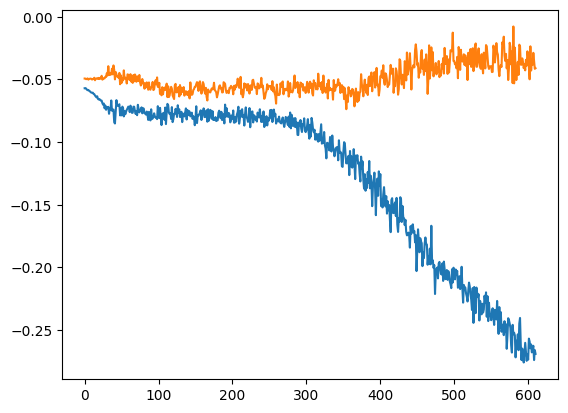

TESTING:  2021-07-09 00:00:00 2023-04-28 00:00:00
result\TCN_2023-05-11_20-46-16.pickle


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
allocation_model = model.NNModel(asset_return, benchmark_return, init_weight_change, configs, configs["portfolio_config"]["model"], device)
result = allocation_model.vanilla_backtesting()
utility.dump_result(configs, result)

<Axes: xlabel='Effective date '>

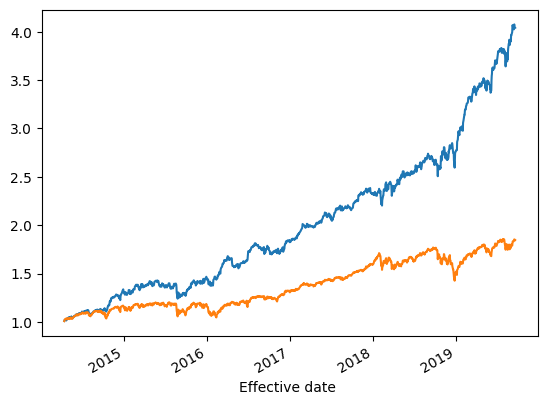

In [31]:
result[0].add(1).cumprod().plot()
benchmark_return[result[0].index[0]:result[0].index[-1]].add(1).cumprod().plot()

<Axes: xlabel='Effective date '>

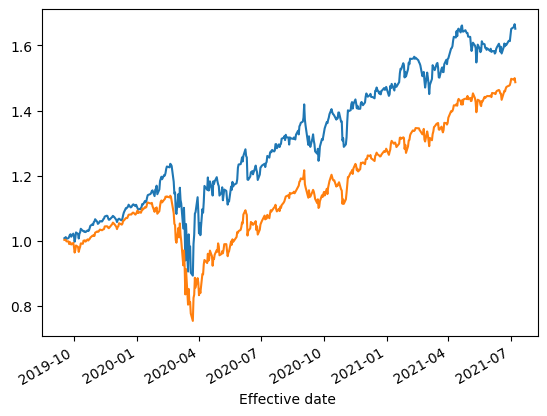

In [29]:
result[1].add(1).cumprod().plot()
benchmark_return[result[1].index[0]:result[1].index[-1]].add(1).cumprod().plot()

<Axes: xlabel='Effective date '>

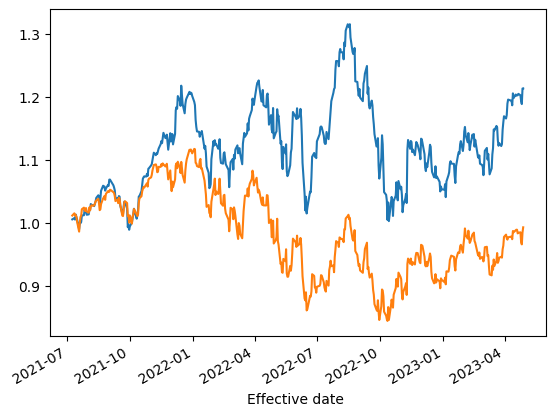

In [30]:
result[2].add(1).cumprod().plot()
benchmark_return[result[2].index[0]:result[2].index[-1]].add(1).cumprod().plot()